# Training a convnet from scratch on a small dataset

### First step
Naively train a small convnet on the training samples, *without regularization*, to set a baseline for what can be achieved.

In [1]:
import os

In [2]:
base_dir = '/tf/data'

# Directories for training, validation and test splits
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


#Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')


# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Directory with test cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')

# Directory with test dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')


Test the paths to the data:

In [ ]:
print('total training cat images:', len(os.listdir(train_cats_dir)))

So we have 2000 training images, 1000 validation images and 1000 test images. Each split contains the **same** number of samples **from each class** => it's a *balanced* binary-classification problem => classification ```accuracy``` is an appropriate measure of success.

#### Building the network
It'll be similar to the MNIST convnet, except that, since we have bigger images and a more complex problem, the network must be larger and thefore, it'll have one more ```Conv2D + MaxPooling2D``` stage, both to:
- augment the capacity of the network
- further reduce the size of the feature map before the ```Flatten``` layer.

>> The **depth** of the feature maps progressively increases in the network, whereas the **size** of the feature maps decreases.

In [3]:
from keras import layers
from keras import models

In [22]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
            input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [5]:
from tensorflow.keras import optimizers

In [23]:
model.compile(loss='binary_crossentropy',
                optimizer=optimizers.RMSprop(learning_rate=1e-4),
                metrics=['acc'])

#### Data preprocessing
- Read the picture files
- Decode the JPEG content to RGB grid of pixels
- Convert these into floating-point tensors
- Rescale the pixel values (between 0 and 255) to the [0,1] interval (to deal with small input values)

To do all these, Keras has a module with image-processing helper tools

In [7]:
from keras.preprocessing.image import ImageDataGenerator

In [26]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                train_dir,
                target_size=(150, 150), # Resizes all images to 150 × 150
                batch_size=20,
                class_mode='binary') # Binary-crossentropy loss => needs
                                     # binary labels

validation_generator = test_datagen.flow_from_directory(
                validation_dir,
                target_size=(150, 150),
                batch_size=20,
                class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


This generators (Python objects that act like iterators, built using the ```yield``` operation) output batches of 150x150 RGB images (batch size is 3, target size is 150x150 and it's RGB, so 3 channels).

NOTE: the generator yields the batches *indefinitely*, so when fitting the model to the data using the generator (```fit_generator``` method), the Keras model needs to know how many samples to draw from the generator before declaring an epoch over => ```steps_per_epoch```. Same if we also pass a ```validation_data``` argument, it needs ```validation_steps``` to know how many batches to draw from the validation generator for evaluation.

**NOTE:** Image transformations require SciPy

Method ```fit_generator``` is now deprecated, method ```fit``` now accepts generators.

In [27]:
history = model.fit(
                train_generator,
                steps_per_epoch=100,
                epochs=30,
                validation_data=validation_generator,
                validation_steps=50)

Epoch 1/30
100/100 [==============================] - 3s 29ms/step - loss: 0.6603 - acc: 0.6170 - val_loss: 0.6437 - val_acc: 0.6460
Epoch 2/30
100/100 [==============================] - 3s 28ms/step - loss: 0.6151 - acc: 0.6650 - val_loss: 0.6131 - val_acc: 0.6660
Epoch 3/30
100/100 [==============================] - 3s 28ms/step - loss: 0.5711 - acc: 0.7045 - val_loss: 0.5908 - val_acc: 0.6820
Epoch 4/30
100/100 [==============================] - 3s 28ms/step - loss: 0.5295 - acc: 0.7305 - val_loss: 0.5841 - val_acc: 0.6900
Epoch 5/30
100/100 [==============================] - 3s 28ms/step - loss: 0.5077 - acc: 0.7440 - val_loss: 0.5938 - val_acc: 0.6850
Epoch 6/30
100/100 [==============================] - 3s 28ms/step - loss: 0.4790 - acc: 0.7725 - val_loss: 0.5784 - val_acc: 0.6880
Epoch 7/30
100/100 [==============================] - 3s 28ms/step - loss: 0.4542 - acc: 0.7820 - val_loss: 0.5792 - val_acc: 0.7010
Epoch 8/30
100/100 [==============================] - 3s 28ms/step - 

It's good practice to save the models after training:

In [29]:
model.save('/tf/data/saved-models/cats_and_dogs_small_1.h5')

#### Plot loss and accuracy

In [15]:
import matplotlib.pyplot as plt

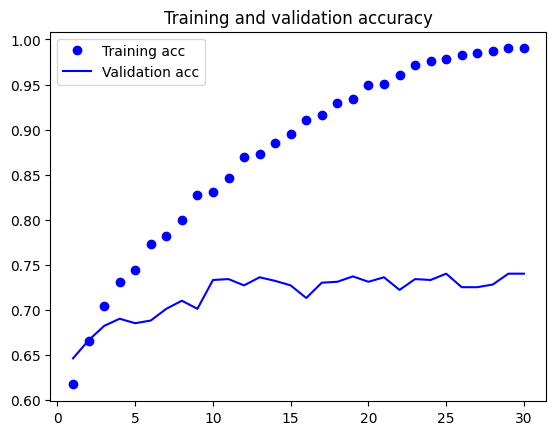

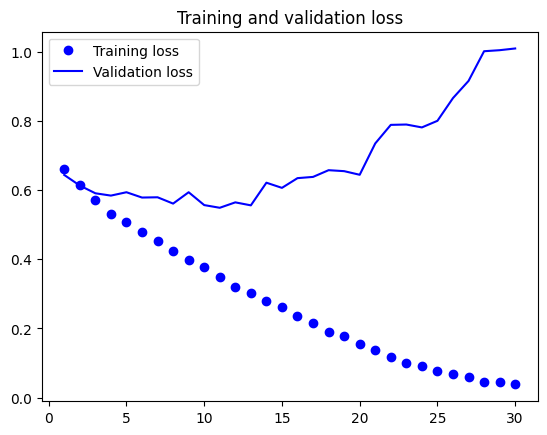

In [30]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

From the plots, we can see clear overfitting, as the *training* accuracy increases linearly to 100%, but the *validation* accuracy stalls at 70-72%.

Same for loss, *validation* loss reaches a minimum after 5 epochs while *training* loss reaches nearly 0.